# ASTR 596: FDS - The Midterm

### Dun, dun dun. 
#### (suspenseful music here)

## Start with the Cepheid data you have already seen in lecture 03 and 04.

## There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

## Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file.

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('../../../data/03/R11ceph.dat')
hosts = ceph.list_hosts()

In [2]:
import pandas as pd

In [3]:
dat = pd.read_csv('../../../data/03/R11ceph.dat',skiprows=19,sep='\s+',usecols=[1,2,3,4],
                  names=['gal','mag','magerr','logP'],header=None)

all_mag = dat['mag']
all_magerr = dat['magerr']
all_logP = dat['logP']

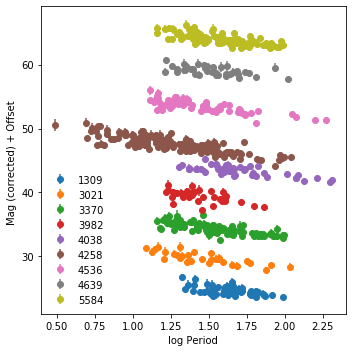

In [4]:
%matplotlib inline
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

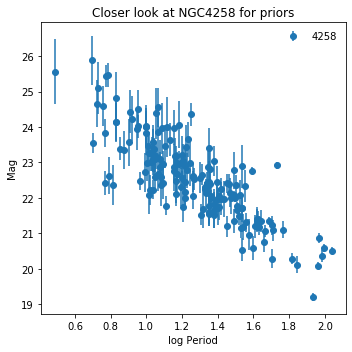

In [5]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ceph.select('4258')
mobs = ceph.mobs
logP = ceph.logP
sigma_obs = ceph.sigma
ax.errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o', label='4258')
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag')
ax.set_title('Closer look at NGC4258 for priors')
fig.tight_layout()

In [6]:
# range of zpw prior to give for a slope of -8 to 0

absolute_distance = mobs - 8*logP
print(np.mean(absolute_distance))

12.424327934391478


# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


In [7]:
intsigma = 0.1 #intrinsic dispersion

def mag_model(logP, mu, zpw, bw):
    m = mu + zpw + bw*logP
    return m

def chisq(mu, zpw, bw, data):
    logP ,y, dy = data[0], data[1], data[2]
    model = mag_model(logP, mu, zpw, bw)
    chisq_val = np.sum(((y - model)**2.)/(dy**2 + intsigma**2))
    
    return chisq_val

#simultaneous fit to all the data which share the same zpw, bw
def net_chisq(x,*args):
    mu1, mu2 , mu3, mu4, mu5, mu7, mu8, mu9, zpw, bw = x
    data1, data2, data3, data4, data5, data6, data7, data8, data9 = args  
    chisq1 = chisq(mu1, zpw, bw, data1)
    chisq2 = chisq(mu2, zpw, bw, data2)
    chisq3 = chisq(mu3, zpw, bw, data3)
    chisq4 = chisq(mu4, zpw, bw, data4)
    chisq5 = chisq(mu5, zpw, bw, data5)
    chisq6 = chisq(0, zpw, bw,  data6)  #reference galaxy 4258 with mu-mu_ref = 0
    chisq7 = chisq(mu7, zpw, bw, data7)
    chisq8 = chisq(mu8, zpw, bw, data8)
    chisq9 = chisq(mu9, zpw, bw, data9)
    
    netchisq = chisq1 + chisq2 + chisq3 + chisq4 + chisq5 + chisq6 + chisq7 + chisq8 + chisq9
    return netchisq
    

def negloglike(x,*args):
    loglike = net_chisq(x,*args)
    return -loglike/2

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

In [8]:
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [9]:
bounds = [(0,5),(0,5),(0,5),(0,5),(0,5),(0,5),(0,5),(0,5), (10,80), (-8,0)]
guess = [0, 0, 0, 0, 0, 0, 0, 0, 20, -3]


args = []
for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    args.append([logP,mobs,sigma_obs])

args = tuple(args) 

res = minimize(net_chisq, guess, args=args, bounds=bounds)
print(res.x)

[ 3.11521813  2.89653593  2.68873077  2.2661821   2.09713901  1.50695624
  2.29068444  2.29148142 26.09813788 -2.85169021]


In [10]:
# add 4258 reference distance from itself to be 0
best_fits = np.insert(res.x,5,0)

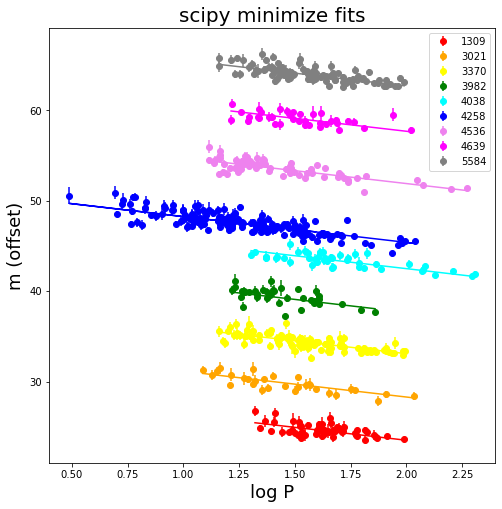

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
colornames = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'violet', 'magenta', 'gray']
for i, ID in enumerate(hosts):
    logP = args[:][i][0]
    mobs = args[:][i][1]
    sigma_obs = args[:][i][2]
    
    ax.errorbar(logP, [x + (5*i) for x in mobs], yerr=sigma_obs, linestyle='None', marker='o', label=ID,
               color=colornames[i])
    ax.plot(logP, mag_model(logP, best_fits[i], float(best_fits[-2:-1]),float(best_fits[-1:]))+(5*i),
           color=colornames[i])
ax.set_title('scipy minimize fits',fontsize=20)
ax.set_xlabel('log P',fontsize=18)
ax.set_ylabel('m (offset)',fontsize=18)

ax.legend()

Explanation for prioirs:

distance from reference galaxy : mu --> Every galaxy's distance is estimated from the reference galaxy (whose distance from itself is taken to be 0). This parameter is > 0

Absolute distance to NGC4258, zpw : Taking the first parameter = 0 and estimating the mean absolute distance for the reference galaxy over a range of slope i.e. -8 to 0

Slope, bw --> there is clearly a negative slope. give a random range of -8 to 0



In [12]:
def log_prior(x):
    mu1, mu2 , mu3, mu4, mu5, mu7, mu8, mu9, zpw, bw = x
    if all(-1.0 < mu < 5.0 for mu in x[0:8]) and 10.0 < zpw < 80.0 and -8.0 < bw < 0.0:
        return 0.0
    else:
        return -np.inf

In [13]:
def log_probability(x,*args):  
    lp = log_prior(x)
    #if not np.isfinite(lp):
    #    return -np.inf
    return lp + negloglike(x,*args)
    #return lp + net_chisq(x,*args)

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [14]:
import emcee

In [15]:
res.x

array([ 3.11521813,  2.89653593,  2.68873077,  2.2661821 ,  2.09713901,
        1.50695624,  2.29068444,  2.29148142, 26.09813788, -2.85169021])

In [16]:
ndim = 10
nwalkers = 1000
nburn = 500
nsteps = 1000

#p0 = np.asarray(res.x)
p0 = np.asarray([ 3.11516988,  2.89647586,  2.68873909,  2.26621124,  2.09698736,
        1.5069504 ,  2.29082187,  2.29148727, 40.0, -2.85165677])
pos = p0 + np.random.normal(0.0, 1.5,(nwalkers,ndim))
#pos = p0 + np.random.randn(nwalkers, ndim)

In [17]:
np.shape(pos)

(1000, 10)

In [18]:
np.shape(pos)

(1000, 10)

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=args)
_ = sampler.run_mcmc(pos, nsteps,rstate0=np.random.get_state())

/Users/sreevani/anaconda3/envs/fds/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


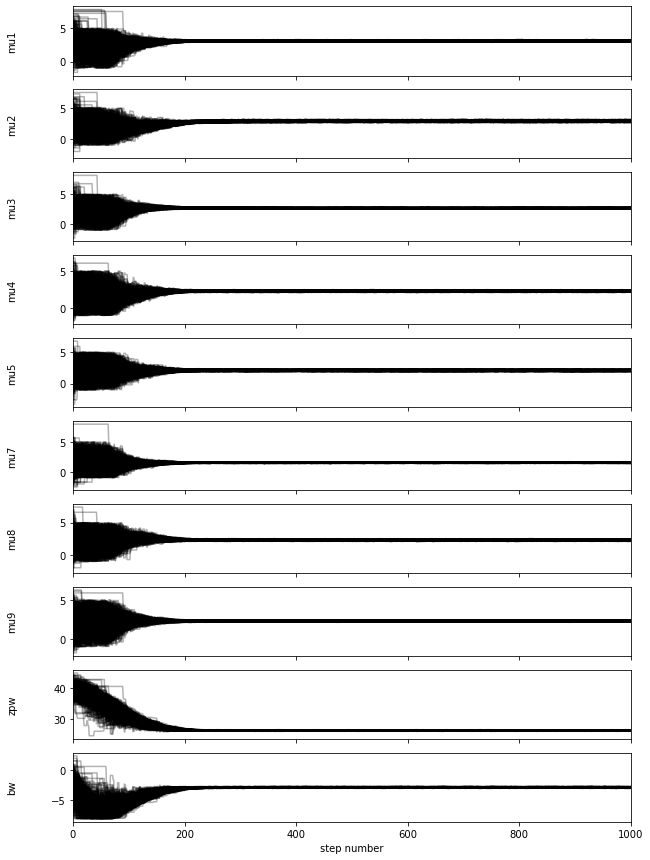

In [20]:
fig, axes = plt.subplots(ndim, figsize=(10, 15), sharex=True)
samples = sampler.get_chain()

labels = ["mu1", "mu2","mu3","mu4","mu5","mu7","mu8","mu9","zpw", "bw"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [21]:
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)

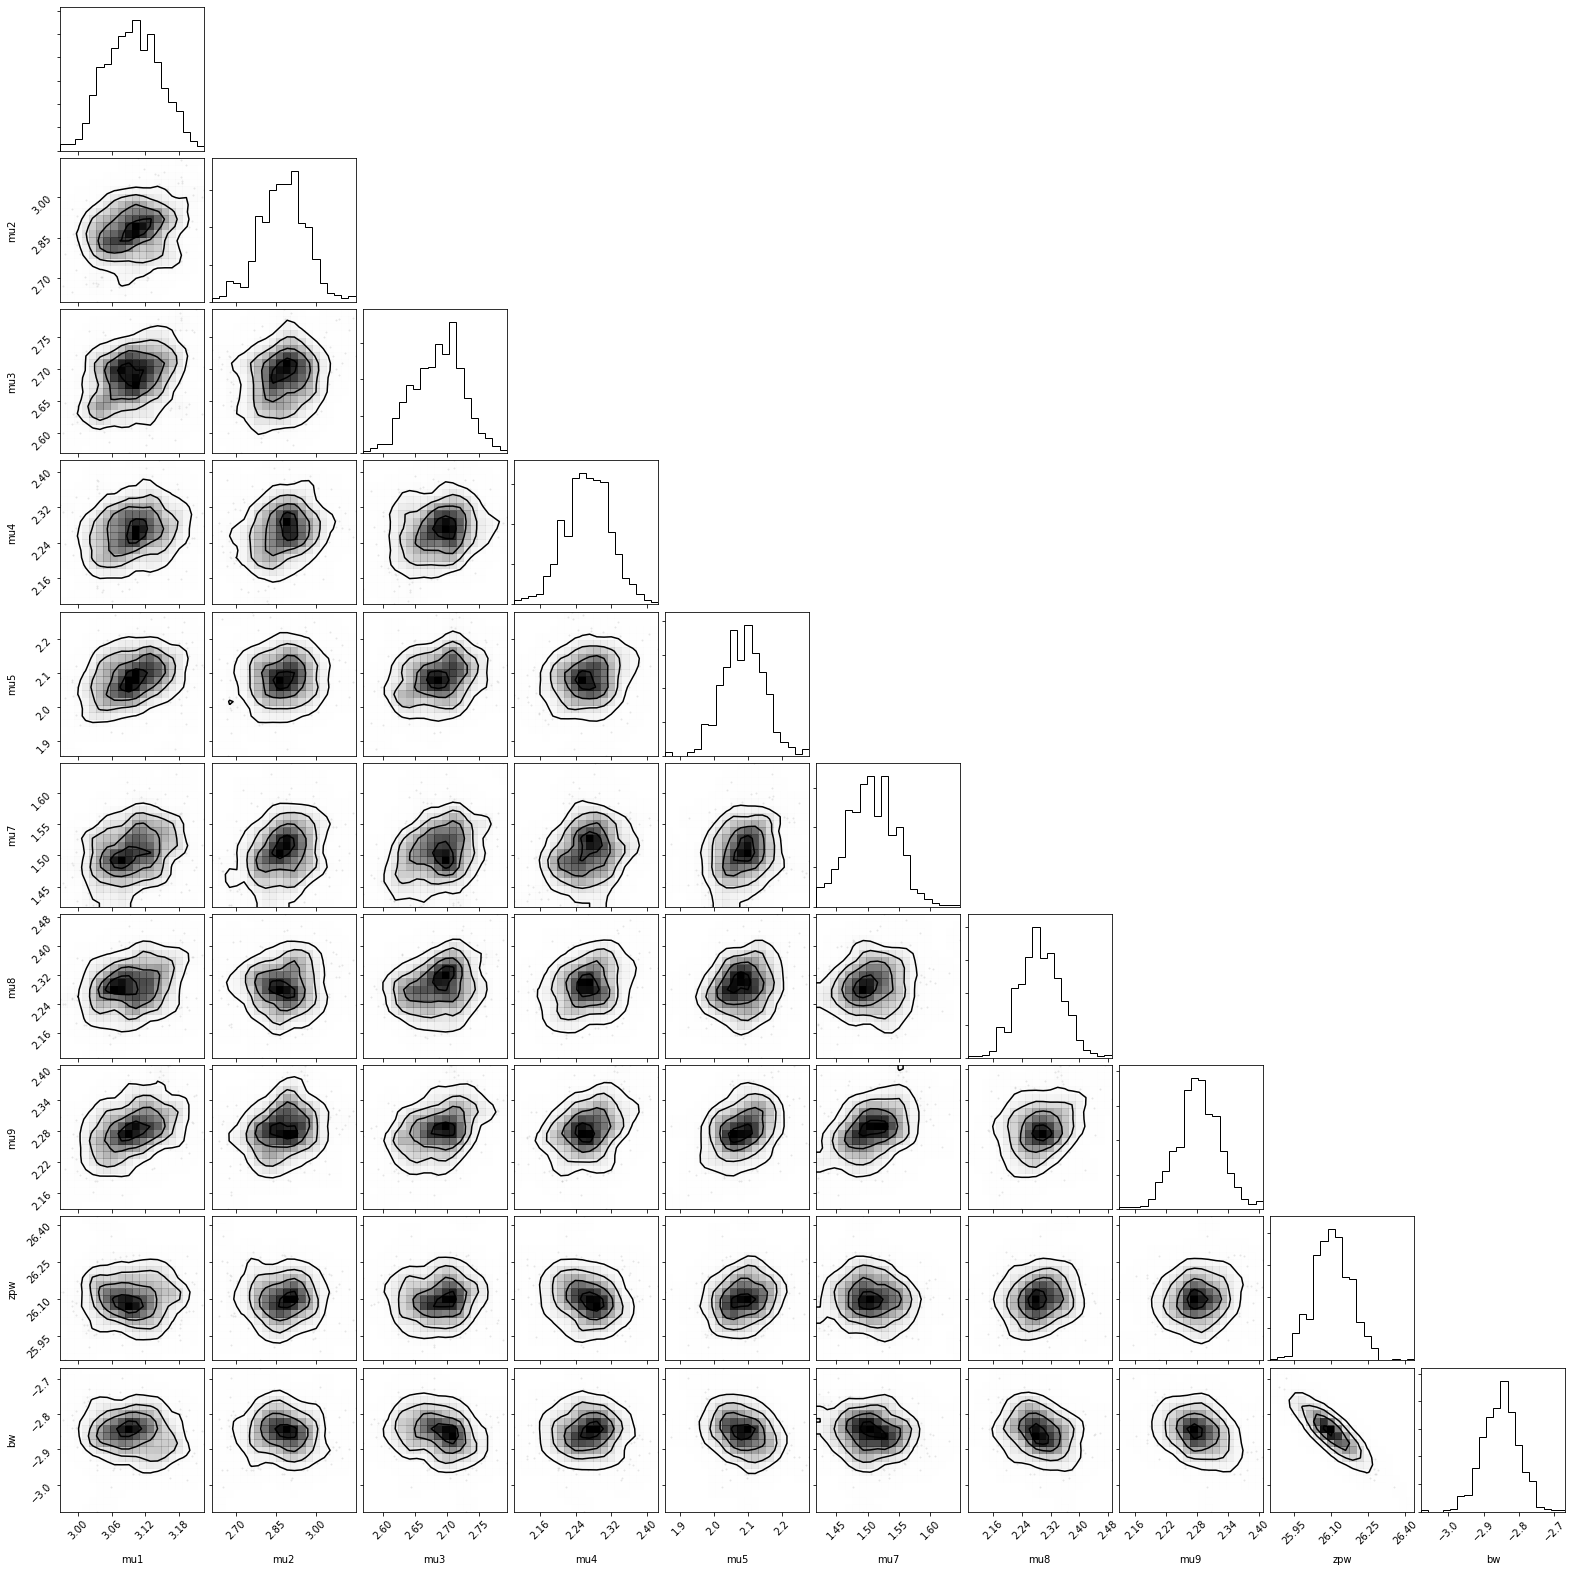

In [22]:
import corner

fig = corner.corner(
    flat_samples[::100], labels=labels,smooth=True);

In [23]:
np.shape(samples[:, :, 0])

(1000, 1000)

In [24]:
#Taking mean and std excluding burn-in

best_fit_mcmc = []
err_best_fit_mcmc = []
for i in range(ndim):
    best_fit_mcmc.append(np.mean(samples[200:, :, i]))
    err_best_fit_mcmc.append(np.std(samples[200:, :, i]))
best_fit_mcmc = np.array(best_fit_mcmc)
err_best_fit_mcmc = np.array(err_best_fit_mcmc)

allbest_fits_mcmc = np.insert(best_fit_mcmc,5,0)
allbest_fits_mcmc

array([ 3.11182148,  2.88301195,  2.69092994,  2.26535691,  2.09769793,
        0.        ,  1.50645723,  2.29368348,  2.29093019, 26.10711355,
       -2.85762113])

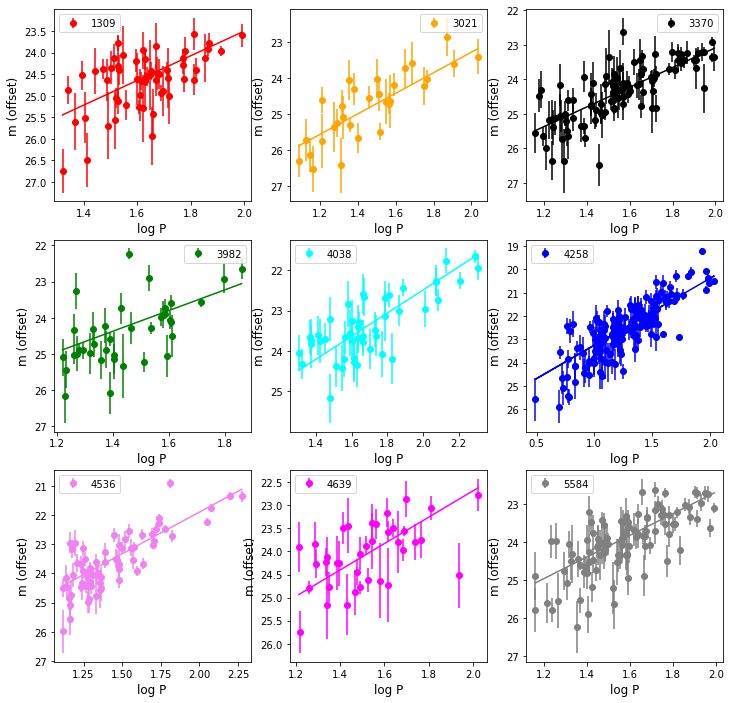

In [25]:
fig = plt.figure(figsize=(12,12))
colornames = ['red', 'orange', 'k', 'green', 'cyan', 'blue', 'violet', 'magenta', 'gray']
for i, ID in enumerate(hosts):
    ax = plt.subplot(3,3,i+1)
    logP = args[:][i][0]
    mobs = args[:][i][1]
    sigma_obs = args[:][i][2]
    
    ax.errorbar(logP, [x for x in mobs], yerr=sigma_obs, linestyle='None', marker='o', label=ID,
               color=colornames[i])
    ax.plot(logP, mag_model(logP, allbest_fits_mcmc[i], float(allbest_fits_mcmc[-2:-1]),\
                            float(allbest_fits_mcmc[-1:])),
           color=colornames[i])
    #ax.plot(logP, mag_model(logP, best_fits[i], float(best_fits[-2:-1]),float(best_fits[-1:]))+(5*i),
    #       color='k',ls='--')

    ax.set_xlabel('log P',fontsize=12)
    ax.set_ylabel('m (offset)',fontsize=12)
    plt.gca().invert_yaxis()
    ax.legend()

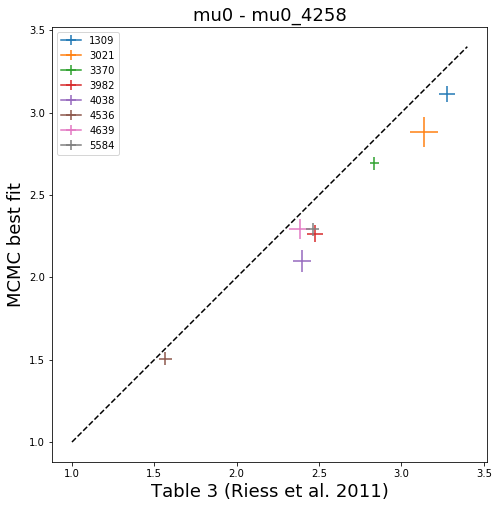

In [26]:
# 1309, 3021, 3370, 3982, 4038, 4536, 4639, 5584
# mu - mu4258
mu_table3 = np.array([ 3.276, 3.138, 2.835, 2.475, 2.396, 1.567,  2.383,  2.461])
err_mu_table3 = np.array([0.0491, 0.0870, 0.0284, 0.0460, 0.0567, 0.0404, 0.0630, 0.0401])
labels = ['1309', '3021', '3370', '3982', '4038', '4536', '4639', '5584']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for i in range(0,len(labels)):
    ax.errorbar(mu_table3[i], best_fit_mcmc[i],xerr= err_mu_table3[i],yerr=err_best_fit_mcmc[i], label=labels[i])
ax.plot(np.arange(1.0,3.5,0.1), np.arange(1.0,3.5,0.1),ls='--',color='k')
ax.set_aspect('equal')
ax.set_title('mu0 - mu0_4258',fontsize=18)
ax.set_xlabel('Table 3 (Riess et al. 2011)',fontsize=18)
ax.set_ylabel('MCMC best fit',fontsize=18)
plt.legend()

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

$$
log H_{0} = \frac{ m^{0}_{v,i} - (\mu_{0,i} - \mu_{0, 4258}) - \mu_{0, 4258} + 5 a_{v} + 25 }{5} = \frac{ ( m^{0}_{v,i} + 5 a_{v}) - (\mu_{0,i} - \mu_{0, 4258}) - \mu_{0, 4258} + 25 }{5}
$$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [27]:
# 1309, 3021, 3370, 3982, 4038, 4536, 4639, 5584

col4_table3 = np.array([16.768, 16.699, 16.545, 15.953, 15.901, 15.147, 16.040, 16.274])
mu0_4258 = float(allbest_fits_mcmc[-2:-1])

In [28]:
mu0_4258

26.107113548586682

In [29]:
#mu0_4258 = 29.287

In [30]:
H0 = []
for i in range(0,len(col4_table3)):
    H0.append(10**((col4_table3[i] - best_fit_mcmc[i] - mu0_4258 + 25)/5.0))
H0 = np.array(H0)

In [31]:
H0

array([74.78865172, 80.50032056, 81.92454023, 75.88022625, 80.0314001 ,
       74.25206788, 77.9584696 , 86.93886412])

#### The absolute value of $\mu_{0, 4258}$ should be 29.287 but the value the mcmc converges to 26.1 which gives H) value > 300 instead of $\sim$ 74